In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature

In [12]:
lookup_df = pd.read_pickle('lookup_20190801_df.pkl')
lookup_df

,metar_gust,hrrr_gust,metar_coords,hrrr_coords_lon,hrrr_coords_lat,hrrr_temp,hrrr_windu,hrrr_windv,hrrr_wind_speed,hrrr_precip_rate
0,0.0,6.42368,"(-110.85, 31.42)",-110.858,31.424,297.571167,-5.548723,-3.178455,6.248435,0.0
1,0.0,6.36118,"(-110.96, 32.13)",-110.951,32.144,297.571167,-5.486223,-3.240955,6.248435,0.0
2,0.0,6.36118,"(-111.17, 32.14)",-111.175,32.143,297.571167,-5.361223,-3.303455,6.185935,0.0
3,0.0,6.29868,"(-111.21, 32.4)",-111.222,32.408,297.571167,-5.298723,-3.303455,6.123435,0.0
4,0.0,6.23618,"(-116.98, 32.57)",-116.979,32.559,297.508667,-5.236223,-3.365955,6.060935,0.0
...,...,...,...,...,...,...,...,...,...,...
1995,0.0,1.86118,"(-89.53, 44.55)",-89.517,44.551,297.696167,0.013777,-1.865955,2.373435,0.0
1996,0.0,1.79868,"(-92.48, 44.58)",-92.495,44.593,297.696167,0.013777,-1.803455,2.310935,0.0
1997,0.0,1.79868,"(-88.73, 44.61)",-88.715,44.606,297.696167,0.013777,-1.803455,2.310935,0.0
1998,0.0,1.79868,"(-90.18, 44.63)",-90.189,44.618,297.696167,0.013777,-1.803455,2.310935,0.0


In [13]:
array = lookup_df.values
X = array[:, 2:9]
y = array[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


scaler = StandardScaler()
rescaled_X_train = (scaler.fit_transform(X_train[:, 5:9])) # doesn't include lon, lat
rescaled_X_test = (scaler.fit_transform(X_test[:, 5:9])) # doesn't include lon, lat

### Training the neural net
Puts strain on the computer, is there a better way? 

In [14]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                   power_t=0.5, max_iter=1500, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp = mlp.fit(rescaled_X_train, y_train)

### Run neural net

In [15]:
y_predict_mlp = mlp.predict(rescaled_X_test)

In [16]:
#y_predict_mlp[y_predict_mlp < 5] = 0

### Plot neural net

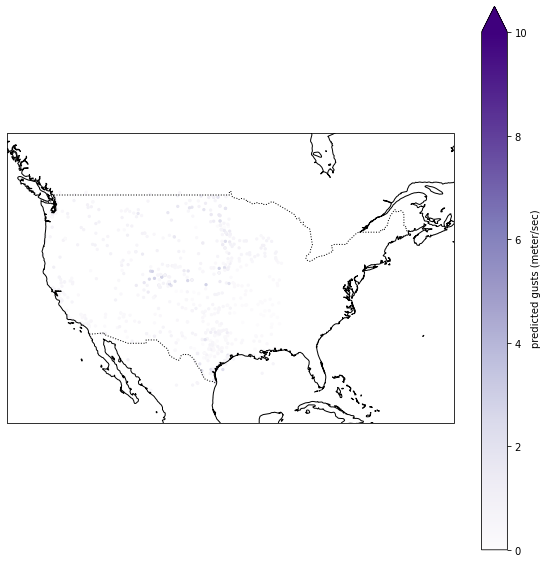

In [17]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 1], X_test[:, 2], c=y_predict_mlp, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

### Plot training set

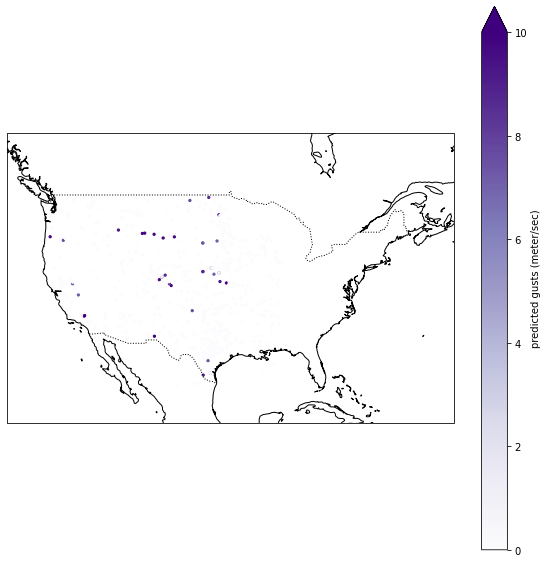

In [18]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 1], X_test[:, 2], c=y_test, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

### Evaluating neural net predictions

In [19]:
print('RMSE:', np.sqrt(
    metrics.mean_squared_error(y_test, y_predict_mlp)).round(4))
print('Mean Absolute Error:', 
    metrics.mean_absolute_error(y_test, y_predict_mlp).round(4))
print('R-Squared Score:', 
    metrics.r2_score(y_test, y_predict_mlp).round(4))

print('Range of Training: ', np.min(y_train), ' to ', np.max(y_train))
print('Range of Test: ', np.min(y_test), ' to ', np.max(y_test))
print('Range of Predictions: ', np.min(y_predict_mlp).round(4), ' to ', np.max(y_predict_mlp).round(4))

RMSE: 2.2
Mean Absolute Error: 1.0531
R-Squared Score: -0.0027
Range of Training:  0.0  to  18.0
Range of Test:  0.0  to  16.5
Range of Predictions:  -0.2373  to  2.8776


Text(0.5, 0, 'Neural Network Gust (m/s)')

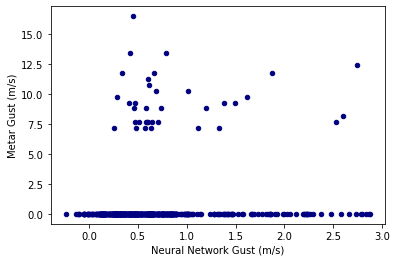

In [20]:
plt.scatter(y_predict_mlp, y_test, c='Navy', s=20)
plt.ylabel("Metar Gust (m/s)", size = 10)
plt.xlabel("Neural Network Gust (m/s)", size = 10)